In [ ]:
install.packages("fastDummies")
library(fastDummies)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages("recipes")
library(recipes)
library(dplyr)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages("glmnet")
install.packages("pROC")   # needed for twoClassSummary

library(glmnet)
library(pROC)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages("caret")
library(caret)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages("ipred")
library(ipred)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(ggplot2)

## --- Global options  ---
options(
  warn   = -1,   # roughly like warnings.filterwarnings('ignore')
  scipen = 999   # avoid scientific notation
)

## ggplot style roughly analogous to sns.set_theme()
theme_set(theme_minimal())

# General Data Imports

In [ ]:
X_train_money <- readr::read_csv("/content/X_train_money.csv")
X_val_money   <- readr::read_csv("/content/X_val_money.csv")


Rows: 6300 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (12): age, avg_transaction_value, max_transaction_value, min_transaction...
lgl  (5): location_Suburban, location_Urban, income_level_Low, app_usage_fre...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 700 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (12): age, avg_transaction_value, max_transaction_value, min_transaction...
lgl  (5): location_Suburban, location_Urban, income_level_Low, app_usage_fre...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
data <- readr::read_csv("/content/digital_wallet_ltv_dataset.csv")

Rows: 7000 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): Customer_ID, Location, Income_Level, App_Usage_Frequency, Preferre...
dbl (15): Age, Total_Transactions, Avg_Transaction_Value, Max_Transaction_Va...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
names(data) <- tolower(names(data))
names(data) <- gsub(" ", "_", names(data))


In [ ]:
data <- dplyr::select(data, -customer_id)


In [ ]:
data <- fastDummies::dummy_cols(
  data,
  remove_first_dummy = TRUE,
  remove_selected_columns = TRUE,
  ignore_na = FALSE
)


In [ ]:
X_t_m <- dplyr::select(data, dplyr::all_of(intersect(names(data), names(X_train_money))))


In [ ]:
median_ltv <- median(data$ltv, na.rm = TRUE)

y_class <- ifelse(data$ltv >= median_ltv, 1, 0)


In [ ]:
y_reg <- data$ltv   # regression target if needed

# Splitting Data into Training and Test

In [ ]:
## Stratified split
set.seed(0)

train_index <- caret::createDataPartition(y_class, p = 0.9, list = FALSE)

X_train <- X_t_m[train_index, ]
X_test  <- X_t_m[-train_index, ]

y_train <- y_class[train_index]
y_test  <- y_class[-train_index]


# Model Prep

In [ ]:
class_names <- c("Low LTV", "High LTV")

In [ ]:
get_scaling <- function(X, scaler = "minmax") {

  # Identify dummy columns: 0/1 and <= 2 unique values
  is_binary <- sapply(X, function(col) {
    all(unique(col) %in% c(0, 1)) && length(unique(col)) <= 2
  })

  dummy_cols <- names(X)[is_binary]
  cont_cols  <- names(X)[!is_binary]

  # Build recipe
  rec <- recipe(~ ., data = X)

  # Add scaling step for continuous variables
  if (tolower(scaler) == "minmax") {
    rec <- rec %>% step_range(all_of(cont_cols))
  } else {
    rec <- rec %>% step_center(all_of(cont_cols)) %>% step_scale(all_of(cont_cols))
  }

  # Dummy vars are passed through untouched — nothing needed

  return(rec)
}


In [ ]:
train_model <- function(m, v, s, score_metric, k) {
  m <- tolower(m)
  v <- tolower(v)
  s <- tolower(s)
  score_metric <- tolower(score_metric)
  k <- tolower(k)

  if (m != "logistic") {
    cat("Invalid model selection. Only 'logistic' is implemented.\n")
    return(NULL)
  }

  ## Choose predictors: with or without monetary features
  if (v == "y") {
    X <- X_train
  } else {
    X <- X_train_without
  }

  ## Build training data frame with factor outcome
  df_train <- as.data.frame(X)

  # Internal class labels (no spaces) so caret is happy
  df_train$y <- factor(
    ifelse(y_train == 1, "HighLTV", "LowLTV"),
    levels = c("HighLTV", "LowLTV")   # HighLTV is the positive class
  )

  ## Cross-validation control
  ctrl <- trainControl(
    method          = "cv",
    number          = 10,
    classProbs      = TRUE,
    summaryFunction = twoClassSummary,   # gives ROC, Sens, Spec
    savePredictions = "final"
  )

  ## Pre-processing (scaling)
  preproc_vec <- if (s == "minmax") "range" else c("center", "scale")

  ## Map sklearn C grid to lambda = 1/C
  C_vals      <- c(0.001, 0.01, 0.1, 1, 10)
  lambda_vals <- 1 / C_vals

  ## Ridge, Lasso, Elastic Net
  tune_grid <- expand.grid(
    alpha  = c(0, 1, 0.3, 0.5, 0.7),
    lambda = lambda_vals
  )

  ## Metric mapping
  metric_name <- if (score_metric == "recall") {
    "Sens"          # sensitivity = recall of HighLTV
  } else if (score_metric == "roc_auc") {
    "ROC"
  } else {
    "Accuracy"
  }

  set.seed(0)
  model_fit <- caret::train(
    y ~ .,
    data       = df_train,
    method     = "glmnet",
    preProcess = preproc_vec,
    trControl  = ctrl,
    tuneGrid   = tune_grid,
    metric     = metric_name
  )

  return(model_fit)
}


## -----------------------------
## Main function (interactive)
## -----------------------------
main <- function() {
  model <- readline("Enter model selection: ")
  value <- readline("Any monetary features? (y/n): ")
  scale <- readline("Enter scaling for continuous features (minmax or standard): ")
  metric <- readline("Enter scoring criterion (recall or roc_auc): ")
  kfold <- readline("Enter type of cross validation (kfold or stratified): ")

  if (tolower(model) == "logistic") {
    return(train_model(model, value, scale, metric, kfold))
  } else {
    cat("Invalid model selection.\n")
    return(NULL)
  }
}


# Quickly Assessing Function

In [ ]:
grid <- main()   # this both sets up AND fits the model

Enter model selection: logistic
Any monetary features? (y/n): y
Enter scaling for continuous features (minmax or standard): minmax
Enter scoring criterion (recall or roc_auc): recall
Enter type of cross validation (kfold or stratified): stratified


In [ ]:
## Interpretation of Selected Parameters (R version of grid.best_params_)

cat("REGULARIZED LOGISTIC REGRESSION\n")

best <- grid$bestTune  # alpha & lambda chosen by caret/glmnet

best_params <- data.frame(
  log__C        = as.numeric(1 / best$lambda),                         # inverse of lambda
  log__l1_ratio = ifelse(best$alpha %in% c(0, 1), NA, best$alpha),     # only meaningful for elastic net
  log__penalty  = ifelse(best$alpha == 0, "l2",
                         ifelse(best$alpha == 1, "l1", "elasticnet")),
  log__solver   = "glmnet",
  row.names     = 1
)

best_params


REGULARIZED LOGISTIC REGRESSION


,log__C,log__l1_ratio,log__penalty,log__solver
,<dbl>,<dbl>,<chr>,<chr>
1,10,0.7,elasticnet,glmnet


# Quick Assessment of Regularized Logistic Regression Performance if use ALL Training Data (Other than ID)

In [ ]:
# all predictors except the response 'ltv'
all_regressors <- dplyr::select(data, -ltv)


In [ ]:
grid <-main()

Enter model selection: logistic
Any monetary features? (y/n): y
Enter scaling for continuous features (minmax or standard): minmax
Enter scoring criterion (recall or roc_auc): recall
Enter type of cross validation (kfold or stratified): stratified


In [ ]:
cat("REGULARIZED LOGISTIC REGRESSION (all regressors)\n")

best <- grid$bestTune
best_params_all <- data.frame(
  log__C        = 1 / best$lambda,
  log__l1_ratio = ifelse(best$alpha %in% c(0, 1), NA, best$alpha),
  log__penalty  = ifelse(best$alpha == 0, "l2",
                         ifelse(best$alpha == 1, "l1", "elasticnet")),
  log__solver   = "glmnet",
  row.names     = 1
)
best_params_all


REGULARIZED LOGISTIC REGRESSION (all regressors)


,log__C,log__l1_ratio,log__penalty,log__solver
,<dbl>,<dbl>,<chr>,<chr>
1,10,0.7,elasticnet,glmnet


In [ ]:
## -------------------------
## Extract Coefficients
## -------------------------

# 1. glmnet stores the best alpha/lambda
best_alpha  <- grid$bestTune$alpha
best_lambda <- grid$bestTune$lambda

# 2. Extract coefficients for the winning model
coef_matrix <- coef(grid$finalModel, s = best_lambda)

# 3. Convert to a tidy data frame
coef_df <- data.frame(
  Feature     = rownames(coef_matrix),
  Coefficient = as.numeric(coef_matrix),
  row.names   = NULL
)

# 4. Rename intercept
coef_df$Feature[coef_df$Feature == "(Intercept)"] <- "intercept"

# 5. Sort by absolute value of coefficient (descending)
coef_df <- coef_df %>%
  dplyr::arrange(desc(abs(Coefficient)))

# 6. Display with scientific format
options(scipen = 999)
coef_df


Feature,Coefficient
<chr>,<dbl>
avg_transaction_value,-2.6099187
intercept,1.4768764
min_transaction_value,-0.3064622
max_transaction_value,-0.2854515
age,0.0000000
active_days,0.0000000
last_transaction_days_ago,0.0000000
loyalty_points_earned,0.0000000
referral_count,0.0000000


In [ ]:
## Get CV results table (caret stores this in grid$results)
cv_df <- grid$results

## Find which metric was optimized (e.g., "Sens", "ROC", "Accuracy")
metric_name <- grid$metric

## Build a table with parameters + mean + std
cv_summary <- cv_df %>%
  dplyr::select(alpha, lambda,
                dplyr::all_of(metric_name),
                dplyr::starts_with(paste0(metric_name, "SD"))) %>%
  dplyr::rename(
    mean_test_score = !!metric_name,
    std_test_score  = dplyr::starts_with(paste0(metric_name, "SD"))
  ) %>%
  dplyr::arrange(desc(mean_test_score))

cv_summary


alpha,lambda,mean_test_score,std_test_score
<dbl>,<dbl>,<dbl>,<dbl>
0.7,0.1,0.7469841,0.02468355
1.0,0.1,0.7463492,0.02474698
0.0,0.1,0.7457143,0.02276731
0.3,0.1,0.7453968,0.02125905
0.5,0.1,0.7444444,0.02133529
0.0,1.0,0.7396825,0.02254738
0.0,10.0,0.7342857,0.02142955
0.0,100.0,0.7342857,0.02142955
0.0,1000.0,0.0000000,0.00000000


In [ ]:
classification_summary <- function(actual, predicted, positive = "HighLTV") {
  cm <- caret::confusionMatrix(predicted, actual, positive = positive)
  print(cm$table)
  cat("\nAccuracy:", round(cm$overall["Accuracy"], 4), "\n")
  cat("Sensitivity (Recall):", round(cm$byClass["Sensitivity"], 4), "\n")
  cat("Specificity:", round(cm$byClass["Specificity"], 4), "\n")
  cat("Precision:", round(cm$byClass["Precision"], 4), "\n")
  cat("F1:", round(cm$byClass["F1"], 4), "\n")
}


In [ ]:
# Convert y_test to factor with the correct label order
y_test_factor <- factor(
  ifelse(y_test == 1, "HighLTV", "LowLTV"),
  levels = c("HighLTV", "LowLTV")
)

# Predict test classes
pred_class <- predict(grid, newdata = X_test)

# Call our replacement function
classification_summary(y_test_factor, pred_class)


          Reference
Prediction HighLTV LowLTV
   HighLTV     260     90
   LowLTV       90    260

Accuracy: 0.7429 
Sensitivity (Recall): 0.7429 
Specificity: 0.7429 
Precision: 0.7429 
F1: 0.7429 


# Decision Tree Using Features To Visualize Influence of Regressors

In [ ]:
cols_dt <- c(
  "avg_transaction_value", "max_transaction_value", "min_transaction_value",
  "support_tickets_raised", "issue_resolution_time", "age", "income_level_Low",
  "customer_satisfaction_score", "app_usage_frequency_Monthly", "referral_count",
  "app_usage_frequency_Weekly", "loyalty_points_earned", "active_days",
  "last_transaction_days_ago", "location_Urban"
)

X_train_dt <- X_train[, cols_dt]
X_test_dt  <- X_test[, cols_dt]


In [ ]:
dt_grid <- expand.grid(
  maxdepth  = seq(2, 12, by = 2),
  minsplit  = c(2, 5, 10),
  minbucket = c(1, 2, 5),
  cp        = 0  # cp = 0 allows tree growth controlled by tuning params
)


In [ ]:
ctrl_dt <- trainControl(
  method = "cv",
  number = 10,
  classProbs = FALSE,
  savePredictions = "final"
)


In [ ]:
set.seed(0)

dt_model <- caret::train(
  x = X_train_dt,
  y = factor(ifelse(y_train == 1, "HighLTV", "LowLTV"),
             levels = c("HighLTV", "LowLTV")),
  method = "rpart2",   # rpart2 supports tuning maxdepth directly
  trControl = ctrl_dt,
  tuneGrid = expand.grid(
    maxdepth = seq(2, 12, by = 2)
  ),
  metric = "Accuracy"   # can switch to "Kappa" but recall not available
)


In [ ]:
pred_dt <- predict(dt_model, newdata = X_test_dt)

y_test_factor <- factor(
  ifelse(y_test == 1, "HighLTV", "LowLTV"),
  levels = c("HighLTV", "LowLTV")
)

classification_summary(y_test_factor, pred_dt)


          Reference
Prediction HighLTV LowLTV
   HighLTV     330    148
   LowLTV       20    202

Accuracy: 0.76 
Sensitivity (Recall): 0.9429 
Specificity: 0.5771 
Precision: 0.6904 
F1: 0.7971 


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: rpart



Best tree depth selected: 2 


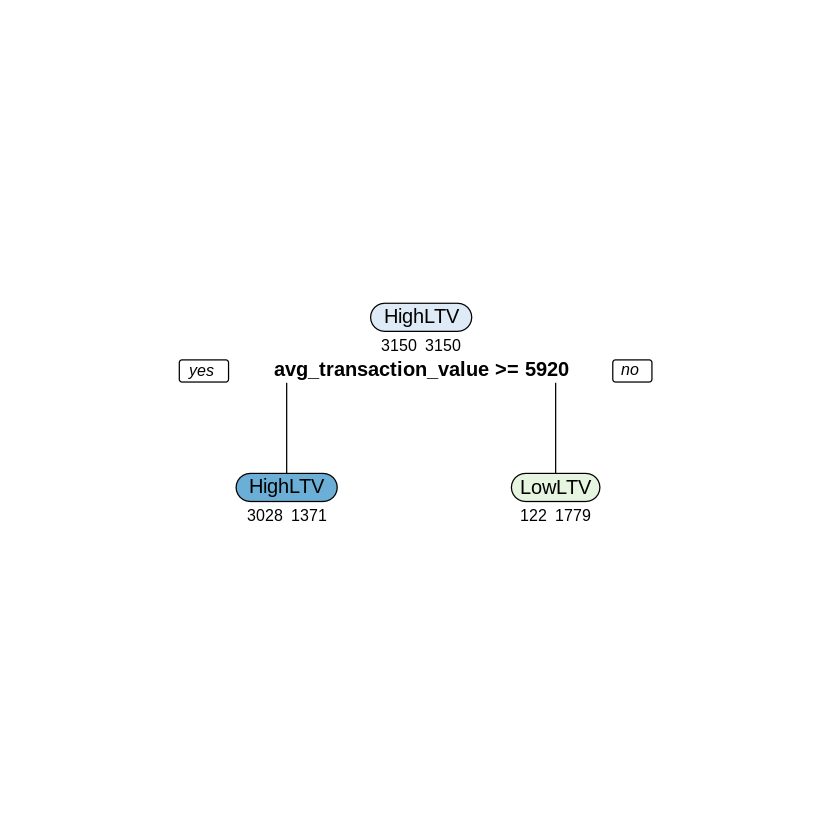

In [ ]:
# If not already loaded
install.packages("rpart.plot")
library(rpart.plot)

# Best depth chosen by caret (from your grid)
best_depth <- dt_model$bestTune$maxdepth
cat("Best tree depth selected:", best_depth, "\n")

# dt_model$finalModel is an rpart object trained at that depth
rpart.plot(
  dt_model$finalModel,
  type  = 2,    # nice split-label style
  extra = 1,    # show class at each node
  under = TRUE, # put node stats under the boxes
  faclen = 0    # don't truncate factor levels
)


# Adjusting definition of "High LTV Customer"

In [ ]:
# 75th percentile (top 25%) of LTV
top_25 <- quantile(data$ltv, probs = 0.75, na.rm = TRUE)

# Binary label: 1 = in top 25% of LTV, 0 = otherwise
ltv_high <- ifelse(data$ltv >= top_25, 1, 0)


In [ ]:
# Same feature matrices as X_train_dt / X_test_dt
X_train <- X_train_dt
X_test  <- X_test_dt


In [ ]:
# Training and test targets for the new definition
y_train <- data.frame(ltv_high = ltv_high[train_index])
y_test  <- data.frame(ltv_high = ltv_high[-train_index])


In [ ]:
round(prop.table(table(y_test$ltv_high)), 2)



   0    1 
0.76 0.24 

# Supervised Learning Using ONLY Nonmonetary features

In [ ]:
library(readr)
library(dplyr)

# 1) Get the non-monetary column names from the CSV header
non_money_cols <- names(read_csv("/content/X_train_without-2.csv"))

# 2) Keep only those columns from the full data
data_without <- data %>%
  dplyr::select(all_of(non_money_cols))

# 3) Use the SAME train/test rows as before
X_train_without <- data_without[train_index, ]
X_test_without  <- data_without[-train_index, ]

# 4) Sanity checks (Python .equals() equivalents)
identical(colnames(X_test_without), colnames(X_train_without))   # should be TRUE
nrow(X_train_without) == nrow(y_train)                        # should be TRUE


Rows: 6300 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): age, active_days, last_transaction_days_ago, loyalty_points_earned,...
lgl (9): location_Suburban, location_Urban, income_level_Low, income_level_M...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] TRUE

[1] TRUE

In [ ]:
grid<-main()

Enter model selection: logistic
Any monetary features? (y/n): n
Enter scaling for continuous features (minmax or standard): minmax
Enter scoring criterion (recall or roc_auc): recall
Enter type of cross validation (kfold or stratified): stratified


In [ ]:
cat("REGULARIZED LOGISTIC REGRESSION (no monetary features)\n")

best <- grid$bestTune

best_params_no_money <- data.frame(
  log__C        = 1 / best$lambda,
  log__l1_ratio = ifelse(best$alpha %in% c(0,1), NA, best$alpha),
  log__penalty  = ifelse(best$alpha == 0, "l2",
                         ifelse(best$alpha == 1, "l1", "elasticnet")),
  log__solver   = "glmnet",
  row.names     = 1
)

best_params_no_money


REGULARIZED LOGISTIC REGRESSION (no monetary features)


,log__C,log__l1_ratio,log__penalty,log__solver
,<dbl>,<lgl>,<chr>,<chr>
1,0.001,NA,l2,glmnet


In [ ]:
pred_no_money <- predict(grid, newdata = X_test_without)

# Convert y_test to correct factor form
y_test_factor <- factor(
  ifelse(y_test$ltv_high == 1, "HighLTV", "LowLTV"),
  levels = c("HighLTV", "LowLTV")
)

# Use replacement classification summary
classification_summary(y_test_factor, pred_no_money)


          Reference
Prediction HighLTV LowLTV
   HighLTV       0      0
   LowLTV      170    530

Accuracy: 0.7571 
Sensitivity (Recall): 0 
Specificity: 1 
Precision: NA 
F1: NA 


In [ ]:
# adjusting scoring metric

In [ ]:
grid<-main()

Enter model selection: logistic
Any monetary features? (y/n): n
Enter scaling for continuous features (minmax or standard): minmax
Enter scoring criterion (recall or roc_auc): roc_auc
Enter type of cross validation (kfold or stratified): stratified


In [ ]:
## ---- Selected coefficients and their weights (no monetary features) ----

# best tuned alpha / lambda
best_alpha  <- grid$bestTune$alpha
best_lambda <- grid$bestTune$lambda

# glmnet coefficient vector at the best lambda
coef_mat <- coef(grid$finalModel, s = best_lambda)

coef_no_money <- data.frame(
  Feature     = rownames(coef_mat),
  Coefficient = as.numeric(coef_mat),
  row.names   = NULL
)

# Make intercept name match your Python table
coef_no_money$Feature[coef_no_money$Feature == "(Intercept)"] <- "intercept"

# Sort by absolute coefficient size (largest first)
coef_no_money <- coef_no_money[order(abs(coef_no_money$Coefficient), decreasing = TRUE), ]

# Optional: pretty printing like Python (fixed 5 decimal places)
coef_no_money$Coefficient <- sprintf("%.8f", coef_no_money$Coefficient)

coef_no_money


,Feature,Coefficient
,<chr>,<chr>
1,intercept,1.09438395
17,support_tickets_raised,0.00000000
15,referral_count,0.00000000
13,last_transaction_days_ago,0.00000000
19,customer_satisfaction_score,-0.00000000
6,app_usage_frequency_Monthly,0.00000000
5,income_level_Middle,-0.00000000
12,active_days,0.00000000
3,location_Urban,-0.00000000


In [ ]:
pred_no_money <- predict(grid, newdata = X_test_without)

# Convert y_test to correct factor form
y_test_factor <- factor(
  ifelse(y_test$ltv_high == 1, "HighLTV", "LowLTV"),
  levels = c("HighLTV", "LowLTV")
)

# Use replacement classification summary
classification_summary(y_test_factor, pred_no_money)


          Reference
Prediction HighLTV LowLTV
   HighLTV       0      0
   LowLTV      170    530

Accuracy: 0.7571 
Sensitivity (Recall): 0 
Specificity: 1 
Precision: NA 
F1: NA 


# Bagging (Bootstrap Aggregation)

In [ ]:
# y_train / y_test are 0/1; make caret-friendly factor
y_train_bag <- factor(
  ifelse(y_train$ltv_high == 1, "HighLTV", "LowLTV"),
  levels = c("HighLTV", "LowLTV")  # HighLTV = positive class
)

y_test_factor <- factor(
  ifelse(y_test$ltv_high == 1, "HighLTV", "LowLTV"),
  levels = c("HighLTV", "LowLTV")
)


In [ ]:
library(caret)   # ipred::bagging is pulled in via method = "treebag"

# 10-fold stratified CV with ROC as scoring (like StratifiedKFold + roc_auc)
ctrl_bag <- trainControl(
  method          = "cv",
  number          = 10,
  classProbs      = TRUE,
  summaryFunction = twoClassSummary,   # gives ROC, Sens, Spec
  savePredictions = "final"
)


# caret's treebag tuning param is nbagg = number of trees
bag_grid <- expand.grid(
  nbagg = c(10, 50, 100)
)


In [ ]:
set.seed(0)

bag_model <- caret::train(
  x         = X_train_without,   # no monetary features
  y         = y_train_bag,
  method    = "treebag",         # ipred bagged decision trees
  trControl = ctrl_bag,
  metric    = "ROC"              # optimize ROC AUC
)

In [ ]:
# Predicted classes on test set
bag_pred_class <- predict(bag_model, newdata = X_test_without)

# If you also want probabilities:
bag_pred_prob  <- predict(bag_model, newdata = X_test_without, type = "prob")[, "HighLTV"]

# Your replacement for dmba::classificationSummary
classification_summary(y_test_factor, bag_pred_class)


          Reference
Prediction HighLTV LowLTV
   HighLTV       2     12
   LowLTV      168    518

Accuracy: 0.7429 
Sensitivity (Recall): 0.0118 
Specificity: 0.9774 
Precision: 0.1429 
F1: 0.0217 


In [ ]:
caret::confusionMatrix(bag_pred_class, y_test_factor, positive = "HighLTV")

Confusion Matrix and Statistics

          Reference
Prediction HighLTV LowLTV
   HighLTV       2     12
   LowLTV      168    518
                                             
               Accuracy : 0.7429             
                 95% CI : (0.7088, 0.7749)   
    No Information Rate : 0.7571             
    P-Value [Acc > NIR] : 0.8229             
                                             
                  Kappa : -0.0158            
                                             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.011765           
            Specificity : 0.977358           
         Pos Pred Value : 0.142857           
         Neg Pred Value : 0.755102           
             Prevalence : 0.242857           
         Detection Rate : 0.002857           
   Detection Prevalence : 0.020000           
      Balanced Accuracy : 0.494562           
                                         

In [ ]:
# Get variable importance from the bagged model
var_importance <- varImp(bag_model)

# Extract the importance data frame
importance_df <- var_importance$importance

# Rename the column for clarity (e.g., to 'Overall' or 'Importance')
names(importance_df) <- c("Importance")

# Add feature names as a column
importance_df$Feature <- rownames(importance_df)

# Sort by importance in descending order
importance_df <- importance_df[order(importance_df$Importance, decreasing = TRUE), ]

# Display the table
print(importance_df)


                                          Importance
active_days                                100.00000
loyalty_points_earned                       99.75196
last_transaction_days_ago                   96.85572
cashback_received                           96.60125
issue_resolution_time                       91.03269
age                                         87.70041
referral_count                              79.07861
support_tickets_raised                      60.78927
customer_satisfaction_score                 46.57213
income_level_Middle                         17.25411
location_Urban                              16.50119
app_usage_frequency_Monthly                 16.43541
location_Suburban                           16.35139
income_level_Low                            16.34839
app_usage_frequency_Weekly                  15.88437
preferred_payment_method_Debit Card         15.47316
preferred_payment_method_Wallet Balance     14.43953
preferred_payment_method_UPI                14

Setting levels: control = 0, case = 1

Setting direction: controls < cases



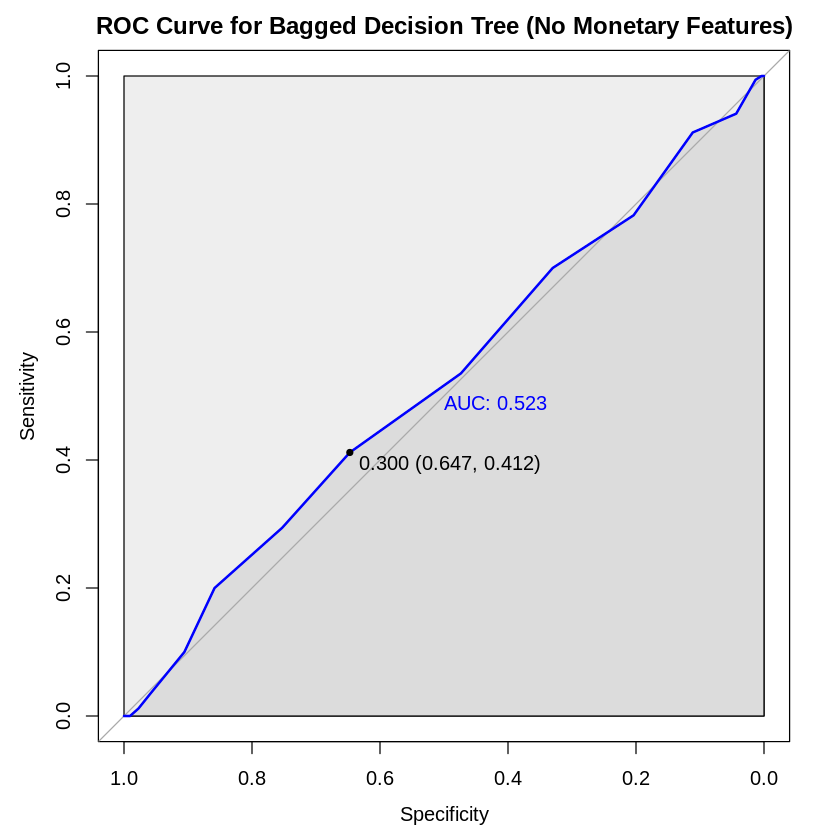

In [ ]:
if (!requireNamespace("pROC", quietly = TRUE)) {
  install.packages("pROC")
}
library(pROC)

# Get predicted probabilities for the 'HighLTV' class from the bag_model
bag_pred_prob <- predict(bag_model, newdata = X_test_without, type = "prob")[, "HighLTV"]

# Convert y_test to a numeric vector (0 or 1)
y_test_numeric <- as.numeric(y_test$ltv_high)

# Create the ROC object
roc_bag_model <- roc(response = y_test_numeric, predictor = bag_pred_prob)

# Plot the ROC curve and print the AUC score on the plot
plot(roc_bag_model, main = "ROC Curve for Bagged Decision Tree (No Monetary Features)",
     col = "blue", lwd = 2, print.auc = TRUE,
     auc.polygon = TRUE, max.auc.polygon = TRUE, print.thres = "best")